In [1]:
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install scikit-learn
import numpy as np
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Loading data
We first load the problem data.

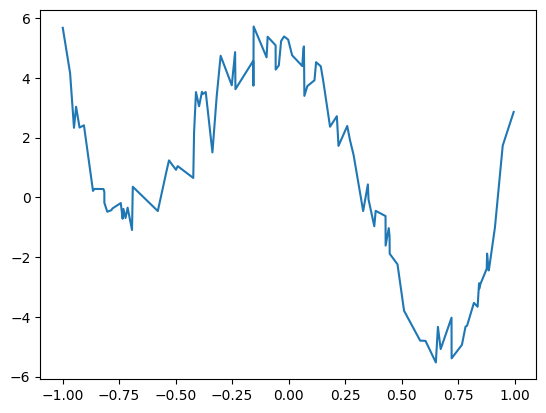

In [2]:
def load_data():
    xy = np.loadtxt('data/y_target.csv', delimiter=",")
    return xy[:,0],xy[:,1]

x,y = load_data()
plt.plot(x,y)

In [3]:
def generate_features(x, deg):
    '''This function generates a design matrix of features for each input point in x
    
    @param x: the input points
    @param deg: the maximum degree of the polynomial basis.
    @return : the design matrix X of dimensions NxD+1, so that the i-th row is the feature vector of the i-th input.
              Each value X_id = f_d(x_i) for the Chebyshev polynomial (of 1st kind) with degree d.
    '''
    n = len(x)
    f = np.ones((n,1))
    for d in range(1, deg+1):
        fd = np.polynomial.chebyshev.chebval(x, np.ones(d+1)) - np.sum(f, axis=1)
        f = np.concatenate((f, fd.reshape(n,1)), axis=1)
    return f

D = 4
X = generate_features(x, D)

In [4]:
from sklearn.linear_model import LinearRegression

# function fit_cheb, that is given a vector of scalar inputs, their labels, and the maximum, degree of the polynomials to use and computes the best linear coefficients wd .
def fit(X,y):
    '''Learns the coefficients of each of the features in the provided matrix that best predicts y.
    @param X: the design matrix of features, one feature per row
    @param y: the vector of the dependent variable (labels)
    @return: vector of coefficients
    '''

    model = LinearRegression(fit_intercept=False).fit(X, y)
    coefficients = model.coef_
    return coefficients

def fit_cheb(x,y,D):
    '''Learns the coefficients of each of the features in the provided matrix that best predicts y.
    @param x: the input points
    @param D: maximum depgree of chebyshev polynomials
    @param y: the vector of the dependent variable (labels)
    @return: vector of coefficients
    '''
    cheb_features = generate_features(x,D)
    coefficients = fit(cheb_features, y)
    return coefficients
    # raise NotImplementedError()

def predict_cheb(coefficents, X,d):
    generated_features = generate_features(X,d)
    y_pred = np.matmul(coefficents, generated_features.T)
    return y_pred
    
w = fit_cheb(x, y, D)
#Check the size of your results:
print(f"{w},  {X.shape}")
y_pred = predict_cheb(w,x ,D)
print(f"{y_pred.shape}")

[ 0.99668433 -1.96466465 -0.12886999  1.0131296   3.74139865],  (100, 5)
(100,)


In [6]:
from utilities import split_data

# Now generate a split of the full data into a taining/.testing dataset.
# The result is an object with named attributes x_trn, x_tst, t_trn, and y_tst.
data = split_data(x, y)
# print(data.x_trn, data.y_trn)

In [7]:
# Fit on the train data and evalute the RSS on the test data

def mse(y,y_pred):
    '''Compute the mean squared error of a prediction and its true label.
    @param y: vector of true labels
    @param y_hat: vector of predictions
    @return: the MSE
    '''
    mse = (np.square(y - y_pred)).mean()
    return mse


    
def evaluate_model_on_dataset(data, deg):
    '''Evaluate our model on the given training/testing set.
    @param data: The object holding the current split.
    @param deg: maximum depgree of chebyshev polynomials
    @return: the MSE of the predictions returned by the model learned on the training data
             as computed against on the testing labels.
    '''
    coef = fit_cheb(data.x_trn, data.y_trn, deg)
    preds = predict_cheb(coef,data.x_tst, deg)
    return mse(data.y_tst, preds)
    

### Evaluation
We now evaluate our models for different degrees.

In [8]:
degs = np.arange(15)
MSEs = np.r_[[evaluate_model_on_dataset(data, deg) for deg in degs]]

In [9]:
plt.bar(degs, MSEs)
plt.xlabel('Maximal Degree')
plt.ylabel('Mean Squared Error')

Text(0, 0.5, 'Mean Squared Error')

##NOTE:
from the maximal degree and the mean squared error, we can realize that the error takes a u-shape with the maxmimal degree, so for small degrees we have large error and then the error decrease while increasing the order of degree until it reaches the minimum value and then with increase of the maximal degree the error is also increasing.

The maximal degree we recommend is 5 since it provided the minimum error

In [10]:
from utilities import split_data_around_point
data_ap = split_data_around_point(x, y, x_0=0.9)

### Evaluation (splits)
We compare the effect of the two different splits on the generalisation error.

Text(0, 0.5, 'Mean Squared Error')

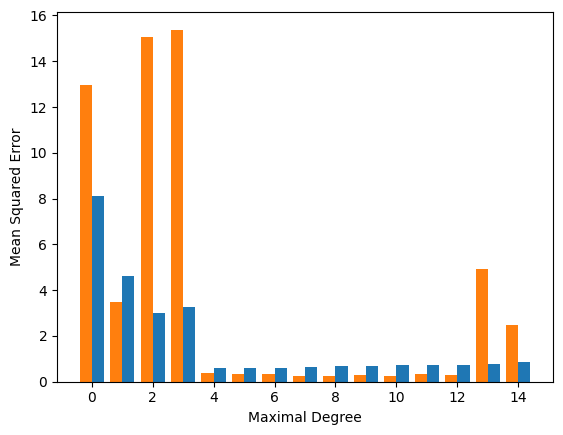

In [11]:
MSEs_ap = np.r_[[evaluate_model_on_dataset(data_ap, deg) for deg in degs]]
plt.bar(degs+.2, MSEs, width=.4)
plt.bar(degs-.2, MSEs_ap, width=.4)
plt.xlabel('Maximal Degree')
plt.ylabel('Mean Squared Error')

#NOTE:
We realized that the data_split technique of the identical sampling provied better results regarding the mse when the degree of freedom is smaller than 4 and bigger than 12, while the split_data_around_point proviedes better results in between.
The good requirements is both the training and testing sets covers the variance and the bais in the sample data.